# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import zipfile
import requests
import os
import pathlib
import numpy as np
import pathlib
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from urllib.parse import urlparse
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Sun May 21 20:01:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    16W / 370W |    339MiB / 10009MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_transformers_jungle_book' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [6]:
dataset_dir = os.path.join('../input', 'the_jungle_book')
train_file = os.listdir(dataset_dir)
print(train_file)

['text.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [7]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 50733 words


In [8]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 1024
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 500

### Helper Functions 

A few helper functions to prepare the dataset.

In [9]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [10]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### The Custom Dataset Class

In [11]:
class NLPDataset():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text_file = open(file_path)
        self.lines = self.text_file.read()
        self.enc = tiktoken.encoding_for_model("gpt2")
    
    def __len__(self):
        return len(self.file_paths)

    def get_data(self):
        final_vector = self.enc.encode(self.lines)
        return torch.tensor(final_vector[0::], dtype=torch.int32)

## Prepare PyTorch Datasets and Data Loaders

In [13]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [14]:
dataset_inst = NLPDataset(file_paths)
dataset = dataset_inst.get_data()

In [15]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([78995])
Number of unique tokens: 6042


In [16]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 71096
Number of validation samples: 7899


In [17]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

71096
7899


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
def get_batch(split='train'):
    device_type = device
    data = dataset_train if split == 'train' else dataset_valid
    ix = torch.randint(len(data) - SEQUENCE_LENGTH, (BATCH_SIZE,))
    x = torch.stack([(data[i:i+SEQUENCE_LENGTH]) for i in ix])
    y = torch.stack([(data[i+1:i+1+SEQUENCE_LENGTH]) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [20]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Training Utilities

In [21]:
# Training function.
def train(model, dataset_train, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    bleu_score = 0
    counter = 0
    for i in tqdm(
        range(0, dataset_train.size(0), SEQUENCE_LENGTH), 
        total=int(dataset_train.size(0)/SEQUENCE_LENGTH)
    ):
        counter += 1
        inputs, labels = get_batch('train')
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs)
        
        labels = labels.contiguous().view(-1)
        outputs = outputs.view(-1, NUM_WORDS)
        # Calculate the loss.
        loss = criterion(
            outputs, 
            labels.type(torch.int64)
        )
        train_running_loss += loss.item()
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    return epoch_loss

# Validation function.
def validate(model, dataset_valid, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i in tqdm(
            range(0, dataset_valid.size(0), SEQUENCE_LENGTH), 
            total=int(dataset_valid.size(0)/SEQUENCE_LENGTH)
        ):
            counter += 1
            inputs, labels = get_batch()
            # Forward pass.
            outputs = model(inputs)
        
            labels = labels.contiguous().view(-1)
            # Calculate the loss.
            loss = criterion(
                outputs.view(-1, NUM_WORDS), 
                labels.type(torch.int64)
            )
            valid_running_loss += loss.item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    return epoch_loss

## Model

In [22]:
model = Transformer(
    embed_dim=1024, 
    src_vocab_size=NUM_WORDS, 
    tgt_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=16,
    device=device
)

In [23]:
_ = model.to(device)

## Training

In [24]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 1024)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): ReLU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (drop

In [25]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, 
                             dataset_train, 
                             optimizer, 
                             criterion, 
                             device)
    valid_epoch_loss = validate(model, 
                                dataset_valid,  
                                criterion, 
                                device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 500
Training



Validation



Training loss: 7.411712612424578
Validation loss: 6.507494747638702
--------------------------------------------------
[INFO]: Epoch 2 of 500
Training



Validation



Training loss: 6.4502431052071705
Validation loss: 6.299988210201263
--------------------------------------------------
[INFO]: Epoch 3 of 500
Training



Validation



Training loss: 6.402742733274187
Validation loss: 6.290396869182587
--------------------------------------------------
[INFO]: Epoch 4 of 500
Training



Validation



Training loss: 6.355435609817505
Validation loss: 6.157249629497528
--------------------------------------------------
[INFO]: Epoch 5 of 500
Training



Validation



Training loss: 5.900481571469988
Validation loss: 5.554030060768127
--------------------------------------------------
[INFO]: Epoch 6 of 500
Training



Validation



Training loss: 5.492731400898525
Validation loss: 5.1913756132125854
--------------------------------------------------
[INFO]: Epoch 7 of 500
Training



Validation



Training loss: 5.249566575459071
Validation loss: 5.0856645703315735
--------------------------------------------------
[INFO]: Epoch 8 of 500
Training



Validation



Training loss: 5.103088351658412
Validation loss: 4.758853018283844
--------------------------------------------------
[INFO]: Epoch 9 of 500
Training



Validation



Training loss: 4.877404240199498
Validation loss: 4.875793397426605
--------------------------------------------------
[INFO]: Epoch 10 of 500
Training



Validation



Training loss: 4.795829037257604
Validation loss: 4.633529186248779
--------------------------------------------------
[INFO]: Epoch 11 of 500
Training



Validation



Training loss: 4.695691088267735
Validation loss: 4.537341088056564
--------------------------------------------------
[INFO]: Epoch 12 of 500
Training



Validation



Training loss: 4.675179427010672
Validation loss: 4.2666813135147095
--------------------------------------------------
[INFO]: Epoch 13 of 500
Training



Validation



Training loss: 4.529771058900016
Validation loss: 4.263558655977249
--------------------------------------------------
[INFO]: Epoch 14 of 500
Training



Validation



Training loss: 4.491773588316781
Validation loss: 4.245038837194443
--------------------------------------------------
[INFO]: Epoch 15 of 500
Training



Validation



Training loss: 4.399990088599068
Validation loss: 4.206302523612976
--------------------------------------------------
[INFO]: Epoch 16 of 500
Training



Validation



Training loss: 4.3604114634650095
Validation loss: 4.282407343387604
--------------------------------------------------
[INFO]: Epoch 17 of 500
Training



Validation



Training loss: 4.3402353967939105
Validation loss: 4.070076018571854
--------------------------------------------------
[INFO]: Epoch 18 of 500
Training



Validation



Training loss: 4.30734463759831
Validation loss: 4.086075812578201
--------------------------------------------------
[INFO]: Epoch 19 of 500
Training



Validation



Training loss: 4.225963357516697
Validation loss: 4.171530544757843
--------------------------------------------------
[INFO]: Epoch 20 of 500
Training



Validation



Training loss: 4.204780398096357
Validation loss: 3.9480164647102356
--------------------------------------------------
[INFO]: Epoch 21 of 500
Training



Validation



Training loss: 4.149833941459656
Validation loss: 3.9867959916591644
--------------------------------------------------
[INFO]: Epoch 22 of 500
Training



Validation



Training loss: 4.1604233060564315
Validation loss: 3.778926521539688
--------------------------------------------------
[INFO]: Epoch 23 of 500
Training



Validation



Training loss: 4.12688330241612
Validation loss: 3.831430584192276
--------------------------------------------------
[INFO]: Epoch 24 of 500
Training



Validation



Training loss: 4.084353232383728
Validation loss: 3.758324086666107
--------------------------------------------------
[INFO]: Epoch 25 of 500
Training



Validation



Training loss: 4.006381249427795
Validation loss: 3.7857409715652466
--------------------------------------------------
[INFO]: Epoch 26 of 500
Training



Validation



Training loss: 4.007488908086504
Validation loss: 3.6991439759731293
--------------------------------------------------
[INFO]: Epoch 27 of 500
Training



Validation



Training loss: 3.9368469681058613
Validation loss: 3.618759870529175
--------------------------------------------------
[INFO]: Epoch 28 of 500
Training



Validation



Training loss: 3.9129690170288085
Validation loss: 3.5497167706489563
--------------------------------------------------
[INFO]: Epoch 29 of 500
Training



Validation



Training loss: 3.876932682309832
Validation loss: 3.6699781119823456
--------------------------------------------------
[INFO]: Epoch 30 of 500
Training



Validation



Training loss: 3.9105999435697285
Validation loss: 3.763898491859436
--------------------------------------------------
[INFO]: Epoch 31 of 500
Training



Validation



Training loss: 3.8055393491472516
Validation loss: 3.7568309903144836
--------------------------------------------------
[INFO]: Epoch 32 of 500
Training



Validation



Training loss: 3.7936686277389526
Validation loss: 3.550756186246872
--------------------------------------------------
[INFO]: Epoch 33 of 500
Training



Validation



Training loss: 3.784730437823704
Validation loss: 3.592516541481018
--------------------------------------------------
[INFO]: Epoch 34 of 500
Training



Validation



Training loss: 3.748428211893354
Validation loss: 3.567455291748047
--------------------------------------------------
[INFO]: Epoch 35 of 500
Training



Validation



Training loss: 3.7030365330832344
Validation loss: 3.4771141707897186
--------------------------------------------------
[INFO]: Epoch 36 of 500
Training



Validation



Training loss: 3.687957835197449
Validation loss: 3.44282528758049
--------------------------------------------------
[INFO]: Epoch 37 of 500
Training



Validation



Training loss: 3.706029299327305
Validation loss: 3.402360439300537
--------------------------------------------------
[INFO]: Epoch 38 of 500
Training



Validation



Training loss: 3.629576015472412
Validation loss: 3.264505922794342
--------------------------------------------------
[INFO]: Epoch 39 of 500
Training



Validation



Training loss: 3.583371949195862
Validation loss: 3.4230955243110657
--------------------------------------------------
[INFO]: Epoch 40 of 500
Training



Validation



Training loss: 3.5819839784077234
Validation loss: 3.400302916765213
--------------------------------------------------
[INFO]: Epoch 41 of 500
Training



Validation



Training loss: 3.623861026763916
Validation loss: 3.349474608898163
--------------------------------------------------
[INFO]: Epoch 42 of 500
Training



Validation



Training loss: 3.560501858166286
Validation loss: 3.4070255160331726
--------------------------------------------------
[INFO]: Epoch 43 of 500
Training



Validation



Training loss: 3.545449195589338
Validation loss: 3.4165609776973724
--------------------------------------------------
[INFO]: Epoch 44 of 500
Training



Validation



Training loss: 3.474404685837882
Validation loss: 3.270703971385956
--------------------------------------------------
[INFO]: Epoch 45 of 500
Training



Validation



Training loss: 3.47399160521371
Validation loss: 3.4088408052921295
--------------------------------------------------
[INFO]: Epoch 46 of 500
Training



Validation



Training loss: 3.451594199453081
Validation loss: 3.462225079536438
--------------------------------------------------
[INFO]: Epoch 47 of 500
Training



Validation



Training loss: 3.439142278262547
Validation loss: 3.1684687435626984
--------------------------------------------------
[INFO]: Epoch 48 of 500
Training



Validation



Training loss: 3.4019702877317157
Validation loss: 3.3692188560962677
--------------------------------------------------
[INFO]: Epoch 49 of 500
Training



Validation



Training loss: 3.4107998711722236
Validation loss: 3.201701194047928
--------------------------------------------------
[INFO]: Epoch 50 of 500
Training



Validation



Training loss: 3.3681392226900373
Validation loss: 3.3426673114299774
--------------------------------------------------
[INFO]: Epoch 51 of 500
Training



Validation



Training loss: 3.3617592232567923
Validation loss: 3.0355575382709503
--------------------------------------------------
[INFO]: Epoch 52 of 500
Training



Validation



Training loss: 3.357775817598615
Validation loss: 3.192710667848587
--------------------------------------------------
[INFO]: Epoch 53 of 500
Training



Validation



Training loss: 3.350552085467747
Validation loss: 3.1337147057056427
--------------------------------------------------
[INFO]: Epoch 54 of 500
Training



Validation



Training loss: 3.339180840764727
Validation loss: 3.044318914413452
--------------------------------------------------
[INFO]: Epoch 55 of 500
Training



Validation



Training loss: 3.2885364873068674
Validation loss: 2.7981970608234406
--------------------------------------------------
[INFO]: Epoch 56 of 500
Training



Validation



Training loss: 3.271247203009469
Validation loss: 2.944682687520981
--------------------------------------------------
[INFO]: Epoch 57 of 500
Training



Validation



Training loss: 3.310200445992606
Validation loss: 2.9340248703956604
--------------------------------------------------
[INFO]: Epoch 58 of 500
Training



Validation



Training loss: 3.2799383674349105
Validation loss: 3.0444957613945007
--------------------------------------------------
[INFO]: Epoch 59 of 500
Training



Validation



Training loss: 3.191560397829328
Validation loss: 3.1518041789531708
--------------------------------------------------
[INFO]: Epoch 60 of 500
Training



Validation



Training loss: 3.2466438838413785
Validation loss: 2.993981420993805
--------------------------------------------------
[INFO]: Epoch 61 of 500
Training



Validation



Training loss: 3.171222972869873
Validation loss: 3.0736750662326813
--------------------------------------------------
[INFO]: Epoch 62 of 500
Training



Validation



Training loss: 3.1218509469713482
Validation loss: 2.9731736183166504
--------------------------------------------------
[INFO]: Epoch 63 of 500
Training



Validation



Training loss: 3.1220806224005564
Validation loss: 2.983793407678604
--------------------------------------------------
[INFO]: Epoch 64 of 500
Training



Validation



Training loss: 3.140949082374573
Validation loss: 2.9369198083877563
--------------------------------------------------
[INFO]: Epoch 65 of 500
Training



Validation



Training loss: 3.2067664691380093
Validation loss: 2.9975607097148895
--------------------------------------------------
[INFO]: Epoch 66 of 500
Training



Validation



Training loss: 3.0916362966809956
Validation loss: 2.9104384183883667
--------------------------------------------------
[INFO]: Epoch 67 of 500
Training



Validation



Training loss: 3.1331743717193605
Validation loss: 2.9501246213912964
--------------------------------------------------
[INFO]: Epoch 68 of 500
Training



Validation



Training loss: 3.1165574312210085
Validation loss: 2.9634419083595276
--------------------------------------------------
[INFO]: Epoch 69 of 500
Training



Validation



Training loss: 3.0811327048710413
Validation loss: 2.8017221093177795
--------------------------------------------------
[INFO]: Epoch 70 of 500
Training



Validation



Training loss: 3.0403203521456037
Validation loss: 2.7816266417503357
--------------------------------------------------
[INFO]: Epoch 71 of 500
Training



Validation



Training loss: 3.049412771633693
Validation loss: 3.061199903488159
--------------------------------------------------
[INFO]: Epoch 72 of 500
Training



Validation



Training loss: 3.0336989436830795
Validation loss: 2.698592931032181
--------------------------------------------------
[INFO]: Epoch 73 of 500
Training



Validation



Training loss: 3.0313799687794276
Validation loss: 2.8824762105941772
--------------------------------------------------
[INFO]: Epoch 74 of 500
Training



Validation



Training loss: 2.9833295856203352
Validation loss: 2.8337625861167908
--------------------------------------------------
[INFO]: Epoch 75 of 500
Training



Validation



Training loss: 3.0134790863309586
Validation loss: 2.9301417469978333
--------------------------------------------------
[INFO]: Epoch 76 of 500
Training



Validation



Training loss: 2.9506994111197336
Validation loss: 2.5794810354709625
--------------------------------------------------
[INFO]: Epoch 77 of 500
Training



Validation



Training loss: 2.9907162870679582
Validation loss: 2.475497826933861
--------------------------------------------------
[INFO]: Epoch 78 of 500
Training



Validation



Training loss: 2.971649408340454
Validation loss: 2.680154025554657
--------------------------------------------------
[INFO]: Epoch 79 of 500
Training



Validation



Training loss: 2.9364074434552876
Validation loss: 2.7165940701961517
--------------------------------------------------
[INFO]: Epoch 80 of 500
Training



Validation



Training loss: 2.9201308829443797
Validation loss: 2.6899700462818146
--------------------------------------------------
[INFO]: Epoch 81 of 500
Training



Validation



Training loss: 2.9596223047801424
Validation loss: 2.5494030714035034
--------------------------------------------------
[INFO]: Epoch 82 of 500
Training



Validation



Training loss: 2.848302275793893
Validation loss: 2.842667818069458
--------------------------------------------------
[INFO]: Epoch 83 of 500
Training



Validation



Training loss: 2.8672442402158467
Validation loss: 2.7168897092342377
--------------------------------------------------
[INFO]: Epoch 84 of 500
Training



Validation



Training loss: 2.8360882248197283
Validation loss: 2.4906542897224426
--------------------------------------------------
[INFO]: Epoch 85 of 500
Training



Validation



Training loss: 2.9134201901299615
Validation loss: 2.6717692017555237
--------------------------------------------------
[INFO]: Epoch 86 of 500
Training



Validation



Training loss: 2.8571071250098092
Validation loss: 2.6096135675907135
--------------------------------------------------
[INFO]: Epoch 87 of 500
Training



Validation



Training loss: 2.800380996295384
Validation loss: 2.519112914800644
--------------------------------------------------
[INFO]: Epoch 88 of 500
Training



Validation



Training loss: 2.7922112464904787
Validation loss: 2.6695724427700043
--------------------------------------------------
[INFO]: Epoch 89 of 500
Training



Validation



Training loss: 2.806766833577837
Validation loss: 2.55462908744812
--------------------------------------------------
[INFO]: Epoch 90 of 500
Training



Validation



Training loss: 2.799590393475124
Validation loss: 2.796774744987488
--------------------------------------------------
[INFO]: Epoch 91 of 500
Training



Validation



Training loss: 2.7688350881849018
Validation loss: 2.5882121324539185
--------------------------------------------------
[INFO]: Epoch 92 of 500
Training



Validation



Training loss: 2.760208933694022
Validation loss: 2.334767669439316
--------------------------------------------------
[INFO]: Epoch 93 of 500
Training



Validation



Training loss: 2.755478620529175
Validation loss: 2.4436646550893784
--------------------------------------------------
[INFO]: Epoch 94 of 500
Training



Validation



Training loss: 2.758410668373108
Validation loss: 2.5935631692409515
--------------------------------------------------
[INFO]: Epoch 95 of 500
Training



Validation



Training loss: 2.7591581310544697
Validation loss: 2.443727046251297
--------------------------------------------------
[INFO]: Epoch 96 of 500
Training



Validation



Training loss: 2.757806951659066
Validation loss: 2.472378671169281
--------------------------------------------------
[INFO]: Epoch 97 of 500
Training



Validation



Training loss: 2.7318994283676146
Validation loss: 2.3870977759361267
--------------------------------------------------
[INFO]: Epoch 98 of 500
Training



Validation



Training loss: 2.6910041502543858
Validation loss: 2.3945141434669495
--------------------------------------------------
[INFO]: Epoch 99 of 500
Training



Validation



Training loss: 2.659152797290257
Validation loss: 2.474911540746689
--------------------------------------------------
[INFO]: Epoch 100 of 500
Training



Validation



Training loss: 2.7029734781810215
Validation loss: 2.5381224751472473
--------------------------------------------------
[INFO]: Epoch 101 of 500
Training



Validation



Training loss: 2.661046382359096
Validation loss: 2.431857392191887
--------------------------------------------------
[INFO]: Epoch 102 of 500
Training



Validation



Training loss: 2.689188473565238
Validation loss: 2.3299367874860764
--------------------------------------------------
[INFO]: Epoch 103 of 500
Training



Validation



Training loss: 2.650181463786534
Validation loss: 2.4800514429807663
--------------------------------------------------
[INFO]: Epoch 104 of 500
Training



Validation



Training loss: 2.7116789375032697
Validation loss: 2.2983808666467667
--------------------------------------------------
[INFO]: Epoch 105 of 500
Training



Validation



Training loss: 2.702570343017578
Validation loss: 2.304503172636032
--------------------------------------------------
[INFO]: Epoch 106 of 500
Training



Validation



Training loss: 2.6298111506870816
Validation loss: 2.4620525538921356
--------------------------------------------------
[INFO]: Epoch 107 of 500
Training



Validation



Training loss: 2.6344974994659425
Validation loss: 2.2660010755062103
--------------------------------------------------
[INFO]: Epoch 108 of 500
Training



Validation



Training loss: 2.5997366666793824
Validation loss: 2.4237812906503677
--------------------------------------------------
[INFO]: Epoch 109 of 500
Training



Validation



Training loss: 2.573880580493382
Validation loss: 2.2898839712142944
--------------------------------------------------
[INFO]: Epoch 110 of 500
Training



Validation



Training loss: 2.5688176700047083
Validation loss: 2.2624295353889465
--------------------------------------------------
[INFO]: Epoch 111 of 500
Training



Validation



Training loss: 2.566753697395325
Validation loss: 2.456562876701355
--------------------------------------------------
[INFO]: Epoch 112 of 500
Training



Validation



Training loss: 2.5835210374423436
Validation loss: 2.359559401869774
--------------------------------------------------
[INFO]: Epoch 113 of 500
Training



Validation



Training loss: 2.581845719473703
Validation loss: 2.2199783623218536
--------------------------------------------------
[INFO]: Epoch 114 of 500
Training



Validation



Training loss: 2.609569617680141
Validation loss: 2.4487197399139404
--------------------------------------------------
[INFO]: Epoch 115 of 500
Training



Validation



Training loss: 2.526505172252655
Validation loss: 2.2977345436811447
--------------------------------------------------
[INFO]: Epoch 116 of 500
Training



Validation



Training loss: 2.512939160210746
Validation loss: 2.269737273454666
--------------------------------------------------
[INFO]: Epoch 117 of 500
Training



Validation



Training loss: 2.5361376149313792
Validation loss: 2.2082676142454147
--------------------------------------------------
[INFO]: Epoch 118 of 500
Training



Validation



Training loss: 2.494160166808537
Validation loss: 2.214400827884674
--------------------------------------------------
[INFO]: Epoch 119 of 500
Training



Validation



Training loss: 2.462566028322492
Validation loss: 2.3177437782287598
--------------------------------------------------
[INFO]: Epoch 120 of 500
Training



Validation



Training loss: 2.5232452426637924
Validation loss: 2.2878824174404144
--------------------------------------------------
[INFO]: Epoch 121 of 500
Training



Validation



Training loss: 2.514304373945509
Validation loss: 2.230325996875763
--------------------------------------------------
[INFO]: Epoch 122 of 500
Training



Validation



Training loss: 2.492175132887704
Validation loss: 2.237882077693939
--------------------------------------------------
[INFO]: Epoch 123 of 500
Training



Validation



Training loss: 2.452214230809893
Validation loss: 2.097575306892395
--------------------------------------------------
[INFO]: Epoch 124 of 500
Training



Validation



Training loss: 2.4203177758625576
Validation loss: 2.0852188169956207
--------------------------------------------------
[INFO]: Epoch 125 of 500
Training



Validation



Training loss: 2.421116369111197
Validation loss: 2.107615828514099
--------------------------------------------------
[INFO]: Epoch 126 of 500
Training



Validation



Training loss: 2.430722965512957
Validation loss: 2.2585631012916565
--------------------------------------------------
[INFO]: Epoch 127 of 500
Training



Validation



Training loss: 2.4329407930374147
Validation loss: 2.2319773733615875
--------------------------------------------------
[INFO]: Epoch 128 of 500
Training



Validation



Training loss: 2.414229839188712
Validation loss: 2.1725338995456696
--------------------------------------------------
[INFO]: Epoch 129 of 500
Training



Validation



Training loss: 2.465987038612366
Validation loss: 2.178555279970169
--------------------------------------------------
[INFO]: Epoch 130 of 500
Training



Validation



Training loss: 2.384907020841326
Validation loss: 2.175804167985916
--------------------------------------------------
[INFO]: Epoch 131 of 500
Training



Validation



Training loss: 2.3865373032433648
Validation loss: 2.150428920984268
--------------------------------------------------
[INFO]: Epoch 132 of 500
Training



Validation



Training loss: 2.392257251058306
Validation loss: 2.1202200949192047
--------------------------------------------------
[INFO]: Epoch 133 of 500
Training



Validation



Training loss: 2.3842923624174936
Validation loss: 2.116385444998741
--------------------------------------------------
[INFO]: Epoch 134 of 500
Training



Validation



Training loss: 2.3537750567708695
Validation loss: 2.156096875667572
--------------------------------------------------
[INFO]: Epoch 135 of 500
Training



Validation



Training loss: 2.3302645819527763
Validation loss: 2.056234911084175
--------------------------------------------------
[INFO]: Epoch 136 of 500
Training



Validation



Training loss: 2.3774000644683837
Validation loss: 1.9929541498422623
--------------------------------------------------
[INFO]: Epoch 137 of 500
Training



Validation



Training loss: 2.3262640033449444
Validation loss: 2.1525333523750305
--------------------------------------------------
[INFO]: Epoch 138 of 500
Training



Validation



Training loss: 2.325920947960445
Validation loss: 2.058651328086853
--------------------------------------------------
[INFO]: Epoch 139 of 500
Training



Validation



Training loss: 2.366353803021567
Validation loss: 2.0383633226156235
--------------------------------------------------
[INFO]: Epoch 140 of 500
Training



Validation



Training loss: 2.3414075493812563
Validation loss: 2.076794058084488
--------------------------------------------------
[INFO]: Epoch 141 of 500
Training



Validation



Training loss: 2.284652062824794
Validation loss: 2.1111553758382797
--------------------------------------------------
[INFO]: Epoch 142 of 500
Training



Validation



Training loss: 2.292619034222194
Validation loss: 2.082095816731453
--------------------------------------------------
[INFO]: Epoch 143 of 500
Training



Validation



Training loss: 2.3038931574140276
Validation loss: 1.9442752003669739
--------------------------------------------------
[INFO]: Epoch 144 of 500
Training



Validation



Training loss: 2.270549089568002
Validation loss: 1.957093432545662
--------------------------------------------------
[INFO]: Epoch 145 of 500
Training



Validation



Training loss: 2.259612839562552
Validation loss: 2.0390107333660126
--------------------------------------------------
[INFO]: Epoch 146 of 500
Training



Validation



Training loss: 2.25892002923148
Validation loss: 1.9557266533374786
--------------------------------------------------
[INFO]: Epoch 147 of 500
Training



Validation



Training loss: 2.289008927345276
Validation loss: 1.9099023938179016
--------------------------------------------------
[INFO]: Epoch 148 of 500
Training



Validation



Training loss: 2.247898939677647
Validation loss: 2.027910605072975
--------------------------------------------------
[INFO]: Epoch 149 of 500
Training



Validation



Training loss: 2.305231317452022
Validation loss: 2.0719339847564697
--------------------------------------------------
[INFO]: Epoch 150 of 500
Training



Validation



Training loss: 2.2416370034217836
Validation loss: 1.8815799951553345
--------------------------------------------------
[INFO]: Epoch 151 of 500
Training



Validation



Training loss: 2.2302693622452874
Validation loss: 1.959114894270897
--------------------------------------------------
[INFO]: Epoch 152 of 500
Training



Validation



Training loss: 2.2094887716429574
Validation loss: 1.9069749414920807
--------------------------------------------------
[INFO]: Epoch 153 of 500
Training



Validation



Training loss: 2.1853484392166136
Validation loss: 1.9431317299604416
--------------------------------------------------
[INFO]: Epoch 154 of 500
Training



Validation



Training loss: 2.242400235789163
Validation loss: 1.90364471077919
--------------------------------------------------
[INFO]: Epoch 155 of 500
Training



Validation



Training loss: 2.222574952670506
Validation loss: 1.9404659122228622
--------------------------------------------------
[INFO]: Epoch 156 of 500
Training



Validation



Training loss: 2.2067461456571307
Validation loss: 1.951716810464859
--------------------------------------------------
[INFO]: Epoch 157 of 500
Training



Validation



Training loss: 2.1695835879870824
Validation loss: 1.8686469942331314
--------------------------------------------------
[INFO]: Epoch 158 of 500
Training



Validation



Training loss: 2.171443828514644
Validation loss: 1.892280951142311
--------------------------------------------------
[INFO]: Epoch 159 of 500
Training



Validation



Training loss: 2.162094872338431
Validation loss: 1.929702267050743
--------------------------------------------------
[INFO]: Epoch 160 of 500
Training



Validation



Training loss: 2.1643583723476953
Validation loss: 1.9219748824834824
--------------------------------------------------
[INFO]: Epoch 161 of 500
Training



Validation



Training loss: 2.15588401385716
Validation loss: 1.8438915759325027
--------------------------------------------------
[INFO]: Epoch 162 of 500
Training



Validation



Training loss: 2.1466724719320025
Validation loss: 1.9260241836309433
--------------------------------------------------
[INFO]: Epoch 163 of 500
Training



Validation



Training loss: 2.1650497555732726
Validation loss: 1.9139766693115234
--------------------------------------------------
[INFO]: Epoch 164 of 500
Training



Validation



Training loss: 2.1544683967317853
Validation loss: 1.810592159628868
--------------------------------------------------
[INFO]: Epoch 165 of 500
Training



Validation



Training loss: 2.1497260860034397
Validation loss: 1.8688073307275772
--------------------------------------------------
[INFO]: Epoch 166 of 500
Training



Validation



Training loss: 2.1357445750917705
Validation loss: 1.8917812258005142
--------------------------------------------------
[INFO]: Epoch 167 of 500
Training



Validation



Training loss: 2.1521140456199648
Validation loss: 1.7810132801532745
--------------------------------------------------
[INFO]: Epoch 168 of 500
Training



Validation



Training loss: 2.137127016271864
Validation loss: 1.8647277653217316
--------------------------------------------------
[INFO]: Epoch 169 of 500
Training



Validation



Training loss: 2.0874928644725252
Validation loss: 1.8442948758602142
--------------------------------------------------
[INFO]: Epoch 170 of 500
Training



Validation



Training loss: 2.065677550860814
Validation loss: 1.8992303013801575
--------------------------------------------------
[INFO]: Epoch 171 of 500
Training



Validation



Training loss: 2.075730196067265
Validation loss: 1.866112932562828
--------------------------------------------------
[INFO]: Epoch 172 of 500
Training



Validation



Training loss: 2.0525170513561792
Validation loss: 1.7709805220365524
--------------------------------------------------
[INFO]: Epoch 173 of 500
Training



Validation



Training loss: 2.0962668929781234
Validation loss: 1.8106334209442139
--------------------------------------------------
[INFO]: Epoch 174 of 500
Training



Validation



Training loss: 2.0464592439787728
Validation loss: 2.010032445192337
--------------------------------------------------
[INFO]: Epoch 175 of 500
Training



Validation



Training loss: 2.1060270820345197
Validation loss: 1.833291932940483
--------------------------------------------------
[INFO]: Epoch 176 of 500
Training



Validation



Training loss: 2.076459661551884
Validation loss: 1.7663919478654861
--------------------------------------------------
[INFO]: Epoch 177 of 500
Training



Validation



Training loss: 2.0297376905168805
Validation loss: 1.8253944963216782
--------------------------------------------------
[INFO]: Epoch 178 of 500
Training



Validation



Training loss: 2.0486819931438993
Validation loss: 1.70943783223629
--------------------------------------------------
[INFO]: Epoch 179 of 500
Training



Validation



Training loss: 2.0673949905804228
Validation loss: 1.831702098250389
--------------------------------------------------
[INFO]: Epoch 180 of 500
Training



Validation



Training loss: 2.0336839522634236
Validation loss: 1.885991707444191
--------------------------------------------------
[INFO]: Epoch 181 of 500
Training



Validation



Training loss: 2.051846102305821
Validation loss: 1.8674994856119156
--------------------------------------------------
[INFO]: Epoch 182 of 500
Training



Validation



Training loss: 2.049068442412785
Validation loss: 1.8563073724508286
--------------------------------------------------
[INFO]: Epoch 183 of 500
Training



Validation



Training loss: 2.0061154093061173
Validation loss: 1.8218486458063126
--------------------------------------------------
[INFO]: Epoch 184 of 500
Training



Validation



Training loss: 2.023438170978001
Validation loss: 1.884986788034439
--------------------------------------------------
[INFO]: Epoch 185 of 500
Training



Validation



Training loss: 2.0474596994263785
Validation loss: 1.773026928305626
--------------------------------------------------
[INFO]: Epoch 186 of 500
Training



Validation



Training loss: 2.0171850647245133
Validation loss: 1.7129331082105637
--------------------------------------------------
[INFO]: Epoch 187 of 500
Training



Validation



Training loss: 1.9923088925225394
Validation loss: 1.8026750087738037
--------------------------------------------------
[INFO]: Epoch 188 of 500
Training



Validation



Training loss: 2.028057714870998
Validation loss: 1.8212313055992126
--------------------------------------------------
[INFO]: Epoch 189 of 500
Training



Validation



Training loss: 2.0264233589172362
Validation loss: 1.7395974844694138
--------------------------------------------------
[INFO]: Epoch 190 of 500
Training



Validation



Training loss: 2.029191058022635
Validation loss: 1.7249023020267487
--------------------------------------------------
[INFO]: Epoch 191 of 500
Training



Validation



Training loss: 2.0298938274383547
Validation loss: 1.787116914987564
--------------------------------------------------
[INFO]: Epoch 192 of 500
Training



Validation



Training loss: 1.9956881301743643
Validation loss: 1.7309042066335678
--------------------------------------------------
[INFO]: Epoch 193 of 500
Training



Validation



Training loss: 1.9845621109008789
Validation loss: 1.7483430355787277
--------------------------------------------------
[INFO]: Epoch 194 of 500
Training



Validation



Training loss: 2.0059545840535846
Validation loss: 1.77195905148983
--------------------------------------------------
[INFO]: Epoch 195 of 500
Training



Validation



Training loss: 1.990390942777906
Validation loss: 1.7163606733083725
--------------------------------------------------
[INFO]: Epoch 196 of 500
Training



Validation



Training loss: 1.9975895472935268
Validation loss: 1.8035067170858383
--------------------------------------------------
[INFO]: Epoch 197 of 500
Training



Validation



Training loss: 1.939559016908918
Validation loss: 1.6595620214939117
--------------------------------------------------
[INFO]: Epoch 198 of 500
Training



Validation



Training loss: 1.944375000681196
Validation loss: 1.770729124546051
--------------------------------------------------
[INFO]: Epoch 199 of 500
Training



Validation



Training loss: 1.9706658448491778
Validation loss: 1.6857558488845825
--------------------------------------------------
[INFO]: Epoch 200 of 500
Training



Validation



Training loss: 1.9405980263437543
Validation loss: 1.7205665856599808
--------------------------------------------------
[INFO]: Epoch 201 of 500
Training



Validation



Training loss: 1.9368807026318142
Validation loss: 1.7620133310556412
--------------------------------------------------
[INFO]: Epoch 202 of 500
Training



Validation



Training loss: 1.9674849561282566
Validation loss: 1.7166099101305008
--------------------------------------------------
[INFO]: Epoch 203 of 500
Training



Validation



Training loss: 1.9720858335494995
Validation loss: 1.5879894495010376
--------------------------------------------------
[INFO]: Epoch 204 of 500
Training



Validation



Training loss: 1.9413511974470956
Validation loss: 1.6914283335208893
--------------------------------------------------
[INFO]: Epoch 205 of 500
Training



Validation



Training loss: 1.9189696754728045
Validation loss: 1.7172884494066238
--------------------------------------------------
[INFO]: Epoch 206 of 500
Training



Validation



Training loss: 1.919310998916626
Validation loss: 1.6416483372449875
--------------------------------------------------
[INFO]: Epoch 207 of 500
Training



Validation



Training loss: 1.935628308568682
Validation loss: 1.7557394206523895
--------------------------------------------------
[INFO]: Epoch 208 of 500
Training



Validation



Training loss: 1.9256748063223703
Validation loss: 1.7336019724607468
--------------------------------------------------
[INFO]: Epoch 209 of 500
Training



Validation



Training loss: 1.9379168152809143
Validation loss: 1.633255735039711
--------------------------------------------------
[INFO]: Epoch 210 of 500
Training



Validation



Training loss: 1.914458189691816
Validation loss: 1.7025492787361145
--------------------------------------------------
[INFO]: Epoch 211 of 500
Training



Validation



Training loss: 1.9101129940577917
Validation loss: 1.703578770160675
--------------------------------------------------
[INFO]: Epoch 212 of 500
Training



Validation



Training loss: 1.9067668693406241
Validation loss: 1.6055938452482224
--------------------------------------------------
[INFO]: Epoch 213 of 500
Training



Validation



Training loss: 1.9039049438067845
Validation loss: 1.6716626286506653
--------------------------------------------------
[INFO]: Epoch 214 of 500
Training



Validation



Training loss: 1.9052681071417672
Validation loss: 1.704093873500824
--------------------------------------------------
[INFO]: Epoch 215 of 500
Training



Validation



Training loss: 1.9332519548279898
Validation loss: 1.752071812748909
--------------------------------------------------
[INFO]: Epoch 216 of 500
Training



Validation



Training loss: 1.9154149055480958
Validation loss: 1.6749888956546783
--------------------------------------------------
[INFO]: Epoch 217 of 500
Training



Validation



Training loss: 1.9462289009775435
Validation loss: 1.6940371543169022
--------------------------------------------------
[INFO]: Epoch 218 of 500
Training



Validation



Training loss: 1.8766761234828404
Validation loss: 1.6475294828414917
--------------------------------------------------
[INFO]: Epoch 219 of 500
Training



Validation



Training loss: 1.935373822280339
Validation loss: 1.6465285122394562
--------------------------------------------------
[INFO]: Epoch 220 of 500
Training



Validation



Training loss: 1.883557437147413
Validation loss: 1.6920017302036285
--------------------------------------------------
[INFO]: Epoch 221 of 500
Training



Validation



Training loss: 1.8519107580184937
Validation loss: 1.6067632883787155
--------------------------------------------------
[INFO]: Epoch 222 of 500
Training



Validation



Training loss: 1.8483160018920899
Validation loss: 1.4983557313680649
--------------------------------------------------
[INFO]: Epoch 223 of 500
Training



Validation



Training loss: 1.8634267227990287
Validation loss: 1.6036952584981918
--------------------------------------------------
[INFO]: Epoch 224 of 500
Training



Validation



Training loss: 1.826180238383157
Validation loss: 1.59030582010746
--------------------------------------------------
[INFO]: Epoch 225 of 500
Training



Validation



Training loss: 1.8789784601756505
Validation loss: 1.6417375802993774
--------------------------------------------------
[INFO]: Epoch 226 of 500
Training



Validation



Training loss: 1.8788228699139187
Validation loss: 1.6330576092004776
--------------------------------------------------
[INFO]: Epoch 227 of 500
Training



Validation



Training loss: 1.879830631187984
Validation loss: 1.687055841088295
--------------------------------------------------
[INFO]: Epoch 228 of 500
Training



Validation



Training loss: 1.8733140570776803
Validation loss: 1.6606551110744476
--------------------------------------------------
[INFO]: Epoch 229 of 500
Training



Validation



Training loss: 1.8531881672995432
Validation loss: 1.6495320051908493
--------------------------------------------------
[INFO]: Epoch 230 of 500
Training



Validation



Training loss: 1.8385087064334324
Validation loss: 1.6906544864177704
--------------------------------------------------
[INFO]: Epoch 231 of 500
Training



Validation



Training loss: 1.874309469972338
Validation loss: 1.5937299579381943
--------------------------------------------------
[INFO]: Epoch 232 of 500
Training



Validation



Training loss: 1.8367812991142274
Validation loss: 1.6163793951272964
--------------------------------------------------
[INFO]: Epoch 233 of 500
Training



Validation



Training loss: 1.8369099055017744
Validation loss: 1.6947596073150635
--------------------------------------------------
[INFO]: Epoch 234 of 500
Training



Validation



Training loss: 1.8467780913625444
Validation loss: 1.5901949256658554
--------------------------------------------------
[INFO]: Epoch 235 of 500
Training



Validation



Training loss: 1.845866140297481
Validation loss: 1.5986833721399307
--------------------------------------------------
[INFO]: Epoch 236 of 500
Training



Validation



Training loss: 1.842565585885729
Validation loss: 1.5724216848611832
--------------------------------------------------
[INFO]: Epoch 237 of 500
Training



Validation



Training loss: 1.8586106726101466
Validation loss: 1.6323222070932388
--------------------------------------------------
[INFO]: Epoch 238 of 500
Training



Validation



Training loss: 1.7972829273768833
Validation loss: 1.6742112338542938
--------------------------------------------------
[INFO]: Epoch 239 of 500
Training



Validation



Training loss: 1.8811983942985535
Validation loss: 1.5903638750314713
--------------------------------------------------
[INFO]: Epoch 240 of 500
Training



Validation



Training loss: 1.8306643128395081
Validation loss: 1.5621371567249298
--------------------------------------------------
[INFO]: Epoch 241 of 500
Training



Validation



Training loss: 1.872473623071398
Validation loss: 1.6120014190673828
--------------------------------------------------
[INFO]: Epoch 242 of 500
Training



Validation



Training loss: 1.8502345613070896
Validation loss: 1.7394463866949081
--------------------------------------------------
[INFO]: Epoch 243 of 500
Training



Validation



Training loss: 1.813465702533722
Validation loss: 1.5607705265283585
--------------------------------------------------
[INFO]: Epoch 244 of 500
Training



Validation



Training loss: 1.8482050316674368
Validation loss: 1.5340962707996368
--------------------------------------------------
[INFO]: Epoch 245 of 500
Training



Validation



Training loss: 1.8331360936164856
Validation loss: 1.594934105873108
--------------------------------------------------
[INFO]: Epoch 246 of 500
Training



Validation



Training loss: 1.7965129903384618
Validation loss: 1.6011658757925034
--------------------------------------------------
[INFO]: Epoch 247 of 500
Training



Validation



Training loss: 1.817176001412528
Validation loss: 1.6032866090536118
--------------------------------------------------
[INFO]: Epoch 248 of 500
Training



Validation



Training loss: 1.834757067476
Validation loss: 1.65035879611969
--------------------------------------------------
[INFO]: Epoch 249 of 500
Training



Validation



Training loss: 1.823113216672625
Validation loss: 1.575694277882576
--------------------------------------------------
[INFO]: Epoch 250 of 500
Training



Validation



Training loss: 1.807250382219042
Validation loss: 1.555314913392067
--------------------------------------------------
[INFO]: Epoch 251 of 500
Training



Validation



Training loss: 1.8197785087994167
Validation loss: 1.5191877335309982
--------------------------------------------------
[INFO]: Epoch 252 of 500
Training



Validation



Training loss: 1.8105777076312475
Validation loss: 1.6338159888982773
--------------------------------------------------
[INFO]: Epoch 253 of 500
Training



Validation



Training loss: 1.8095860821860177
Validation loss: 1.5924352556467056
--------------------------------------------------
[INFO]: Epoch 254 of 500
Training



Validation



Training loss: 1.8124371119907925
Validation loss: 1.5828772187232971
--------------------------------------------------
[INFO]: Epoch 255 of 500
Training



Validation



Training loss: 1.7998599341937473
Validation loss: 1.536958709359169
--------------------------------------------------
[INFO]: Epoch 256 of 500
Training



Validation



Training loss: 1.785756598200117
Validation loss: 1.5957932472229004
--------------------------------------------------
[INFO]: Epoch 257 of 500
Training



Validation



Training loss: 1.795168457712446
Validation loss: 1.5925393551588058
--------------------------------------------------
[INFO]: Epoch 258 of 500
Training



Validation



Training loss: 1.7693140745162963
Validation loss: 1.5687239170074463
--------------------------------------------------
[INFO]: Epoch 259 of 500
Training



Validation



Training loss: 1.7761087094034467
Validation loss: 1.5539516806602478
--------------------------------------------------
[INFO]: Epoch 260 of 500
Training



Validation



Training loss: 1.760625559943063
Validation loss: 1.569151982665062
--------------------------------------------------
[INFO]: Epoch 261 of 500
Training



Validation



Training loss: 1.7542731625693184
Validation loss: 1.6133477538824081
--------------------------------------------------
[INFO]: Epoch 262 of 500
Training



Validation



Training loss: 1.7767506190708706
Validation loss: 1.5364713668823242
--------------------------------------------------
[INFO]: Epoch 263 of 500
Training



Validation



Training loss: 1.7983648334230695
Validation loss: 1.5252839773893356
--------------------------------------------------
[INFO]: Epoch 264 of 500
Training



Validation



Training loss: 1.7674057398523604
Validation loss: 1.6318892389535904
--------------------------------------------------
[INFO]: Epoch 265 of 500
Training



Validation



Training loss: 1.7855677366256715
Validation loss: 1.5721504986286163
--------------------------------------------------
[INFO]: Epoch 266 of 500
Training



Validation



Training loss: 1.7638716561453682
Validation loss: 1.56308975815773
--------------------------------------------------
[INFO]: Epoch 267 of 500
Training



Validation



Training loss: 1.756119988645826
Validation loss: 1.5745729207992554
--------------------------------------------------
[INFO]: Epoch 268 of 500
Training



Validation



Training loss: 1.7630466324942453
Validation loss: 1.579866573214531
--------------------------------------------------
[INFO]: Epoch 269 of 500
Training



Validation



Training loss: 1.7562296083995275
Validation loss: 1.5666678994894028
--------------------------------------------------
[INFO]: Epoch 270 of 500
Training



Validation



Training loss: 1.7459835938044956
Validation loss: 1.5271424502134323
--------------------------------------------------
[INFO]: Epoch 271 of 500
Training



Validation



Training loss: 1.7447786126817977
Validation loss: 1.533983662724495
--------------------------------------------------
[INFO]: Epoch 272 of 500
Training



Validation



Training loss: 1.7543703760419573
Validation loss: 1.5812629610300064
--------------------------------------------------
[INFO]: Epoch 273 of 500
Training



Validation



Training loss: 1.7768081630979264
Validation loss: 1.5568225383758545
--------------------------------------------------
[INFO]: Epoch 274 of 500
Training



Validation



Training loss: 1.7361644881112235
Validation loss: 1.5888065248727798
--------------------------------------------------
[INFO]: Epoch 275 of 500
Training



Validation



Training loss: 1.765142297744751
Validation loss: 1.48668172955513
--------------------------------------------------
[INFO]: Epoch 276 of 500
Training



Validation



Training loss: 1.7564027752195086
Validation loss: 1.5442388653755188
--------------------------------------------------
[INFO]: Epoch 277 of 500
Training



Validation



Training loss: 1.7596749186515808
Validation loss: 1.5708624571561813
--------------------------------------------------
[INFO]: Epoch 278 of 500
Training



Validation



Training loss: 1.7672462037631445
Validation loss: 1.569541484117508
--------------------------------------------------
[INFO]: Epoch 279 of 500
Training



Validation



Training loss: 1.7539640716144016
Validation loss: 1.525445505976677
--------------------------------------------------
[INFO]: Epoch 280 of 500
Training



Validation



Training loss: 1.7278517246246339
Validation loss: 1.5147840976715088
--------------------------------------------------
[INFO]: Epoch 281 of 500
Training



Validation



Training loss: 1.7273514679500035
Validation loss: 1.5584102272987366
--------------------------------------------------
[INFO]: Epoch 282 of 500
Training



Validation



Training loss: 1.7347511444772994
Validation loss: 1.5224819779396057
--------------------------------------------------
[INFO]: Epoch 283 of 500
Training



Validation



Training loss: 1.7285992877823966
Validation loss: 1.5050016939640045
--------------------------------------------------
[INFO]: Epoch 284 of 500
Training



Validation



Training loss: 1.7104990908077784
Validation loss: 1.5205520689487457
--------------------------------------------------
[INFO]: Epoch 285 of 500
Training



Validation



Training loss: 1.7161103555134365
Validation loss: 1.4783798903226852
--------------------------------------------------
[INFO]: Epoch 286 of 500
Training



Validation



Training loss: 1.729565177645002
Validation loss: 1.5221957564353943
--------------------------------------------------
[INFO]: Epoch 287 of 500
Training



Validation



Training loss: 1.7327656660761153
Validation loss: 1.5793603211641312
--------------------------------------------------
[INFO]: Epoch 288 of 500
Training



Validation



Training loss: 1.7271674803325108
Validation loss: 1.4774472117424011
--------------------------------------------------
[INFO]: Epoch 289 of 500
Training



Validation



Training loss: 1.7198721528053285
Validation loss: 1.5338380336761475
--------------------------------------------------
[INFO]: Epoch 290 of 500
Training



Validation



Training loss: 1.7403881941522872
Validation loss: 1.543357014656067
--------------------------------------------------
[INFO]: Epoch 291 of 500
Training



Validation



Training loss: 1.7323273982320513
Validation loss: 1.5115832537412643
--------------------------------------------------
[INFO]: Epoch 292 of 500
Training



Validation



Training loss: 1.7288147909300668
Validation loss: 1.5388275980949402
--------------------------------------------------
[INFO]: Epoch 293 of 500
Training



Validation



Training loss: 1.7286446946007865
Validation loss: 1.5115335434675217
--------------------------------------------------
[INFO]: Epoch 294 of 500
Training



Validation



Training loss: 1.7185007333755493
Validation loss: 1.543881744146347
--------------------------------------------------
[INFO]: Epoch 295 of 500
Training



Validation



Training loss: 1.7272051300321307
Validation loss: 1.5658178478479385
--------------------------------------------------
[INFO]: Epoch 296 of 500
Training



Validation



Training loss: 1.7021233916282654
Validation loss: 1.5600544810295105
--------------------------------------------------
[INFO]: Epoch 297 of 500
Training



Validation



Training loss: 1.724482899052756
Validation loss: 1.5141528844833374
--------------------------------------------------
[INFO]: Epoch 298 of 500
Training



Validation



Training loss: 1.68898218699864
Validation loss: 1.4708012491464615
--------------------------------------------------
[INFO]: Epoch 299 of 500
Training



Validation



Training loss: 1.7116119078227452
Validation loss: 1.4755353033542633
--------------------------------------------------
[INFO]: Epoch 300 of 500
Training



Validation



Training loss: 1.7044269050870622
Validation loss: 1.4572916477918625
--------------------------------------------------
[INFO]: Epoch 301 of 500
Training



Validation



Training loss: 1.6789913739476885
Validation loss: 1.4837865829467773
--------------------------------------------------
[INFO]: Epoch 302 of 500
Training



Validation



Training loss: 1.7108812229973929
Validation loss: 1.553115040063858
--------------------------------------------------
[INFO]: Epoch 303 of 500
Training



Validation



Training loss: 1.705050083569118
Validation loss: 1.518219843506813
--------------------------------------------------
[INFO]: Epoch 304 of 500
Training



Validation



Training loss: 1.7172896436282568
Validation loss: 1.5192635208368301
--------------------------------------------------
[INFO]: Epoch 305 of 500
Training



Validation



Training loss: 1.6972360508782522
Validation loss: 1.4974478483200073
--------------------------------------------------
[INFO]: Epoch 306 of 500
Training



Validation



Training loss: 1.7185175333704268
Validation loss: 1.5080695152282715
--------------------------------------------------
[INFO]: Epoch 307 of 500
Training



Validation



Training loss: 1.704754764693124
Validation loss: 1.5180876106023788
--------------------------------------------------
[INFO]: Epoch 308 of 500
Training



Validation



Training loss: 1.6800392355237688
Validation loss: 1.4743636548519135
--------------------------------------------------
[INFO]: Epoch 309 of 500
Training



Validation



Training loss: 1.6861605984824044
Validation loss: 1.5739135295152664
--------------------------------------------------
[INFO]: Epoch 310 of 500
Training



Validation



Training loss: 1.708275135925838
Validation loss: 1.56169031560421
--------------------------------------------------
[INFO]: Epoch 311 of 500
Training



Validation



Training loss: 1.6965341789381845
Validation loss: 1.54099902510643
--------------------------------------------------
[INFO]: Epoch 312 of 500
Training



Validation



Training loss: 1.7143091474260603
Validation loss: 1.508546695113182
--------------------------------------------------
[INFO]: Epoch 313 of 500
Training



Validation



Training loss: 1.691961089202336
Validation loss: 1.4649531841278076
--------------------------------------------------
[INFO]: Epoch 314 of 500
Training



Validation



Training loss: 1.72574702330998
Validation loss: 1.4768423736095428
--------------------------------------------------
[INFO]: Epoch 315 of 500
Training



Validation



Training loss: 1.6796128068651472
Validation loss: 1.5373890548944473
--------------------------------------------------
[INFO]: Epoch 316 of 500
Training



Validation



Training loss: 1.6873951281820025
Validation loss: 1.481447234749794
--------------------------------------------------
[INFO]: Epoch 317 of 500
Training



Validation



Training loss: 1.6860193831580026
Validation loss: 1.5929395705461502
--------------------------------------------------
[INFO]: Epoch 318 of 500
Training



Validation



Training loss: 1.710674328463418
Validation loss: 1.5201656818389893
--------------------------------------------------
[INFO]: Epoch 319 of 500
Training



Validation



Training loss: 1.6698042563029698
Validation loss: 1.4719013720750809
--------------------------------------------------
[INFO]: Epoch 320 of 500
Training



Validation



Training loss: 1.6771407059260777
Validation loss: 1.5047418475151062
--------------------------------------------------
[INFO]: Epoch 321 of 500
Training



Validation



Training loss: 1.6591753431728908
Validation loss: 1.4709008932113647
--------------------------------------------------
[INFO]: Epoch 322 of 500
Training



Validation



Training loss: 1.6849623799324036
Validation loss: 1.5037063658237457
--------------------------------------------------
[INFO]: Epoch 323 of 500
Training



Validation



Training loss: 1.6863113284111022
Validation loss: 1.4837188422679901
--------------------------------------------------
[INFO]: Epoch 324 of 500
Training



Validation



Training loss: 1.6820958648409163
Validation loss: 1.4643048495054245
--------------------------------------------------
[INFO]: Epoch 325 of 500
Training



Validation



Training loss: 1.6806760089738029
Validation loss: 1.5531244724988937
--------------------------------------------------
[INFO]: Epoch 326 of 500
Training



Validation



Training loss: 1.701932626111167
Validation loss: 1.4906658083200455
--------------------------------------------------
[INFO]: Epoch 327 of 500
Training



Validation



Training loss: 1.6748690451894488
Validation loss: 1.4724347740411758
--------------------------------------------------
[INFO]: Epoch 328 of 500
Training



Validation



Training loss: 1.661299797466823
Validation loss: 1.508452296257019
--------------------------------------------------
[INFO]: Epoch 329 of 500
Training



Validation



Training loss: 1.6801043953214372
Validation loss: 1.5015792697668076
--------------------------------------------------
[INFO]: Epoch 330 of 500
Training



Validation



Training loss: 1.6730563402175904
Validation loss: 1.5203351825475693
--------------------------------------------------
[INFO]: Epoch 331 of 500
Training



Validation



Training loss: 1.6656865307262965
Validation loss: 1.4837592244148254
--------------------------------------------------
[INFO]: Epoch 332 of 500
Training



Validation



Training loss: 1.6682373523712157
Validation loss: 1.4168499857187271
--------------------------------------------------
[INFO]: Epoch 333 of 500
Training



Validation



Training loss: 1.6714412672179086
Validation loss: 1.5070895552635193
--------------------------------------------------
[INFO]: Epoch 334 of 500
Training



Validation



Training loss: 1.6765773517744882
Validation loss: 1.4815880507230759
--------------------------------------------------
[INFO]: Epoch 335 of 500
Training



Validation



Training loss: 1.6613266127450126
Validation loss: 1.5112235099077225
--------------------------------------------------
[INFO]: Epoch 336 of 500
Training



Validation



Training loss: 1.655513310432434
Validation loss: 1.5666182935237885
--------------------------------------------------
[INFO]: Epoch 337 of 500
Training



Validation



Training loss: 1.654763296672276
Validation loss: 1.4646782875061035
--------------------------------------------------
[INFO]: Epoch 338 of 500
Training



Validation



Training loss: 1.665356583254678
Validation loss: 1.523879125714302
--------------------------------------------------
[INFO]: Epoch 339 of 500
Training



Validation



Training loss: 1.6656949417931692
Validation loss: 1.4653596132993698
--------------------------------------------------
[INFO]: Epoch 340 of 500
Training



Validation



Training loss: 1.6595511998449053
Validation loss: 1.525373175740242
--------------------------------------------------
[INFO]: Epoch 341 of 500
Training



Validation



Training loss: 1.6706050974982125
Validation loss: 1.481533721089363
--------------------------------------------------
[INFO]: Epoch 342 of 500
Training



Validation



Training loss: 1.6874123079436165
Validation loss: 1.5165065377950668
--------------------------------------------------
[INFO]: Epoch 343 of 500
Training



Validation



Training loss: 1.6540223326001848
Validation loss: 1.449558362364769
--------------------------------------------------
[INFO]: Epoch 344 of 500
Training



Validation



Training loss: 1.6517650706427438
Validation loss: 1.5066940188407898
--------------------------------------------------
[INFO]: Epoch 345 of 500
Training



Validation



Training loss: 1.644082478114537
Validation loss: 1.486093446612358
--------------------------------------------------
[INFO]: Epoch 346 of 500
Training



Validation



Training loss: 1.6730914405414037
Validation loss: 1.493775099515915
--------------------------------------------------
[INFO]: Epoch 347 of 500
Training



Validation



Training loss: 1.6341885958399092
Validation loss: 1.4466201215982437
--------------------------------------------------
[INFO]: Epoch 348 of 500
Training



Validation



Training loss: 1.6463689463479179
Validation loss: 1.484774887561798
--------------------------------------------------
[INFO]: Epoch 349 of 500
Training



Validation



Training loss: 1.6429139477866037
Validation loss: 1.4586997032165527
--------------------------------------------------
[INFO]: Epoch 350 of 500
Training



Validation



Training loss: 1.653190893786294
Validation loss: 1.4580016136169434
--------------------------------------------------
[INFO]: Epoch 351 of 500
Training



Validation



Training loss: 1.6440991469791957
Validation loss: 1.488209143280983
--------------------------------------------------
[INFO]: Epoch 352 of 500
Training



Validation



Training loss: 1.652783341067178
Validation loss: 1.4311698526144028
--------------------------------------------------
[INFO]: Epoch 353 of 500
Training



Validation



Training loss: 1.6421544109072004
Validation loss: 1.4831963926553726
--------------------------------------------------
[INFO]: Epoch 354 of 500
Training



Validation



Training loss: 1.6329657469476972
Validation loss: 1.4600737392902374
--------------------------------------------------
[INFO]: Epoch 355 of 500
Training



Validation



Training loss: 1.6491256764956883
Validation loss: 1.4270064681768417
--------------------------------------------------
[INFO]: Epoch 356 of 500
Training



Validation



Training loss: 1.6721514054707118
Validation loss: 1.467046394944191
--------------------------------------------------
[INFO]: Epoch 357 of 500
Training



Validation



Training loss: 1.6720013771738325
Validation loss: 1.4716914892196655
--------------------------------------------------
[INFO]: Epoch 358 of 500
Training



Validation



Training loss: 1.6598446556500026
Validation loss: 1.478128805756569
--------------------------------------------------
[INFO]: Epoch 359 of 500
Training



Validation



Training loss: 1.652523228100368
Validation loss: 1.4543811082839966
--------------------------------------------------
[INFO]: Epoch 360 of 500
Training



Validation



Training loss: 1.656395047051566
Validation loss: 1.4711569547653198
--------------------------------------------------
[INFO]: Epoch 361 of 500
Training



Validation



Training loss: 1.6518291405269079
Validation loss: 1.5090961456298828
--------------------------------------------------
[INFO]: Epoch 362 of 500
Training



Validation



Training loss: 1.6715671641486032
Validation loss: 1.4556657373905182
--------------------------------------------------
[INFO]: Epoch 363 of 500
Training



Validation



Training loss: 1.630466227872031
Validation loss: 1.4647923558950424
--------------------------------------------------
[INFO]: Epoch 364 of 500
Training



Validation



Training loss: 1.6363786731447492
Validation loss: 1.4624490141868591
--------------------------------------------------
[INFO]: Epoch 365 of 500
Training



Validation



Training loss: 1.6428681918552943
Validation loss: 1.5025203227996826
--------------------------------------------------
[INFO]: Epoch 366 of 500
Training



Validation



Training loss: 1.6218416639736721
Validation loss: 1.436587005853653
--------------------------------------------------
[INFO]: Epoch 367 of 500
Training



Validation



Training loss: 1.6352433051381792
Validation loss: 1.4993356466293335
--------------------------------------------------
[INFO]: Epoch 368 of 500
Training



Validation



Training loss: 1.6487031170300075
Validation loss: 1.5017339885234833
--------------------------------------------------
[INFO]: Epoch 369 of 500
Training



Validation



Training loss: 1.64219981942858
Validation loss: 1.4997882395982742
--------------------------------------------------
[INFO]: Epoch 370 of 500
Training



Validation



Training loss: 1.611438478742327
Validation loss: 1.5021937191486359
--------------------------------------------------
[INFO]: Epoch 371 of 500
Training



Validation



Training loss: 1.6347899488040378
Validation loss: 1.489961877465248
--------------------------------------------------
[INFO]: Epoch 372 of 500
Training



Validation



Training loss: 1.6384507622037614
Validation loss: 1.4340738654136658
--------------------------------------------------
[INFO]: Epoch 373 of 500
Training



Validation



Training loss: 1.638178426878793
Validation loss: 1.4909053295850754
--------------------------------------------------
[INFO]: Epoch 374 of 500
Training



Validation



Training loss: 1.644000700541905
Validation loss: 1.5082727074623108
--------------------------------------------------
[INFO]: Epoch 375 of 500
Training



Validation



Training loss: 1.6262579321861268
Validation loss: 1.406682550907135
--------------------------------------------------
[INFO]: Epoch 376 of 500
Training



Validation



Training loss: 1.6525727425302779
Validation loss: 1.3982276320457458
--------------------------------------------------
[INFO]: Epoch 377 of 500
Training



Validation



Training loss: 1.6202978542872837
Validation loss: 1.460855707526207
--------------------------------------------------
[INFO]: Epoch 378 of 500
Training



Validation



Training loss: 1.6331355111939567
Validation loss: 1.4699583947658539
--------------------------------------------------
[INFO]: Epoch 379 of 500
Training



Validation



Training loss: 1.63346300806318
Validation loss: 1.5028336495161057
--------------------------------------------------
[INFO]: Epoch 380 of 500
Training



Validation



Training loss: 1.6348492503166199
Validation loss: 1.4260534197092056
--------------------------------------------------
[INFO]: Epoch 381 of 500
Training



Validation



Training loss: 1.6330717529569354
Validation loss: 1.4990813881158829
--------------------------------------------------
[INFO]: Epoch 382 of 500
Training



Validation



Training loss: 1.6381753717150007
Validation loss: 1.5390987545251846
--------------------------------------------------
[INFO]: Epoch 383 of 500
Training



Validation



Training loss: 1.6314657296453203
Validation loss: 1.4870396256446838
--------------------------------------------------
[INFO]: Epoch 384 of 500
Training



Validation



Training loss: 1.6258625302995955
Validation loss: 1.4330176562070847
--------------------------------------------------
[INFO]: Epoch 385 of 500
Training



Validation



Training loss: 1.6228328483445305
Validation loss: 1.4556601792573929
--------------------------------------------------
[INFO]: Epoch 386 of 500
Training



Validation



Training loss: 1.6235895650727408
Validation loss: 1.4677844047546387
--------------------------------------------------
[INFO]: Epoch 387 of 500
Training



Validation



Training loss: 1.6270735604422433
Validation loss: 1.4696117341518402
--------------------------------------------------
[INFO]: Epoch 388 of 500
Training



Validation



Training loss: 1.6111023426055908
Validation loss: 1.5210617035627365
--------------------------------------------------
[INFO]: Epoch 389 of 500
Training



Validation



Training loss: 1.6215758034161158
Validation loss: 1.4260114580392838
--------------------------------------------------
[INFO]: Epoch 390 of 500
Training



Validation



Training loss: 1.6139551145689828
Validation loss: 1.424860641360283
--------------------------------------------------
[INFO]: Epoch 391 of 500
Training



Validation



Training loss: 1.6095813206263951
Validation loss: 1.4565774947404861
--------------------------------------------------
[INFO]: Epoch 392 of 500
Training



Validation



Training loss: 1.628120424066271
Validation loss: 1.4942951202392578
--------------------------------------------------
[INFO]: Epoch 393 of 500
Training



Validation



Training loss: 1.6221431033951896
Validation loss: 1.4884620308876038
--------------------------------------------------
[INFO]: Epoch 394 of 500
Training



Validation



Training loss: 1.6134464876992363
Validation loss: 1.4503402262926102
--------------------------------------------------
[INFO]: Epoch 395 of 500
Training



Validation



Training loss: 1.6355179633413042
Validation loss: 1.4283694326877594
--------------------------------------------------
[INFO]: Epoch 396 of 500
Training



Validation



Training loss: 1.6392998456954957
Validation loss: 1.4426535665988922
--------------------------------------------------
[INFO]: Epoch 397 of 500
Training



Validation



Training loss: 1.6150629946163721
Validation loss: 1.4837026000022888
--------------------------------------------------
[INFO]: Epoch 398 of 500
Training



Validation



Training loss: 1.616421857901982
Validation loss: 1.437156081199646
--------------------------------------------------
[INFO]: Epoch 399 of 500
Training



Validation



Training loss: 1.6128279668944223
Validation loss: 1.5061662048101425
--------------------------------------------------
[INFO]: Epoch 400 of 500
Training



Validation



Training loss: 1.6108307480812072
Validation loss: 1.484046995639801
--------------------------------------------------
[INFO]: Epoch 401 of 500
Training



Validation



Training loss: 1.6147970727511816
Validation loss: 1.4319677948951721
--------------------------------------------------
[INFO]: Epoch 402 of 500
Training



Validation



Training loss: 1.617298117705754
Validation loss: 1.4980167746543884
--------------------------------------------------
[INFO]: Epoch 403 of 500
Training



Validation



Training loss: 1.599709870134081
Validation loss: 1.4531311690807343
--------------------------------------------------
[INFO]: Epoch 404 of 500
Training



Validation



Training loss: 1.6122319970812116
Validation loss: 1.4888281971216202
--------------------------------------------------
[INFO]: Epoch 405 of 500
Training



Validation



Training loss: 1.6292208450181143
Validation loss: 1.470870241522789
--------------------------------------------------
[INFO]: Epoch 406 of 500
Training



Validation



Training loss: 1.6297059331621442
Validation loss: 1.4530553221702576
--------------------------------------------------
[INFO]: Epoch 407 of 500
Training



Validation



Training loss: 1.6128649030412947
Validation loss: 1.485990509390831
--------------------------------------------------
[INFO]: Epoch 408 of 500
Training



Validation



Training loss: 1.6098955512046813
Validation loss: 1.450183555483818
--------------------------------------------------
[INFO]: Epoch 409 of 500
Training



Validation



Training loss: 1.6039844019072396
Validation loss: 1.4343270510435104
--------------------------------------------------
[INFO]: Epoch 410 of 500
Training



Validation



Training loss: 1.599638330936432
Validation loss: 1.4347572326660156
--------------------------------------------------
[INFO]: Epoch 411 of 500
Training



Validation



Training loss: 1.6362406730651855
Validation loss: 1.484738290309906
--------------------------------------------------
[INFO]: Epoch 412 of 500
Training



Validation



Training loss: 1.609944336754935
Validation loss: 1.462926372885704
--------------------------------------------------
[INFO]: Epoch 413 of 500
Training



Validation



Training loss: 1.6019515940121243
Validation loss: 1.4208729565143585
--------------------------------------------------
[INFO]: Epoch 414 of 500
Training



Validation



Training loss: 1.5962840574128287
Validation loss: 1.4208186715841293
--------------------------------------------------
[INFO]: Epoch 415 of 500
Training



Validation



Training loss: 1.594744838987078
Validation loss: 1.4339611232280731
--------------------------------------------------
[INFO]: Epoch 416 of 500
Training



Validation



Training loss: 1.610751063483102
Validation loss: 1.5062765926122665
--------------------------------------------------
[INFO]: Epoch 417 of 500
Training



Validation



Training loss: 1.620187062876565
Validation loss: 1.4658085405826569
--------------------------------------------------
[INFO]: Epoch 418 of 500
Training



Validation



Training loss: 1.604144081047603
Validation loss: 1.4775333255529404
--------------------------------------------------
[INFO]: Epoch 419 of 500
Training



Validation



Training loss: 1.580144156728472
Validation loss: 1.4756510853767395
--------------------------------------------------
[INFO]: Epoch 420 of 500
Training



Validation



Training loss: 1.590318603175027
Validation loss: 1.4253222048282623
--------------------------------------------------
[INFO]: Epoch 421 of 500
Training



Validation



Training loss: 1.600556174346379
Validation loss: 1.51593816280365
--------------------------------------------------
[INFO]: Epoch 422 of 500
Training



Validation



Training loss: 1.601579523086548
Validation loss: 1.4397372603416443
--------------------------------------------------
[INFO]: Epoch 423 of 500
Training



Validation



Training loss: 1.5967147486550468
Validation loss: 1.453196942806244
--------------------------------------------------
[INFO]: Epoch 424 of 500
Training



Validation



Training loss: 1.604560571057456
Validation loss: 1.481136754155159
--------------------------------------------------
[INFO]: Epoch 425 of 500
Training



Validation



Training loss: 1.586470719746181
Validation loss: 1.4612039029598236
--------------------------------------------------
[INFO]: Epoch 426 of 500
Training



Validation



Training loss: 1.583112873349871
Validation loss: 1.4772276431322098
--------------------------------------------------
[INFO]: Epoch 427 of 500
Training



Validation



Training loss: 1.5826206309454782
Validation loss: 1.4958258271217346
--------------------------------------------------
[INFO]: Epoch 428 of 500
Training



Validation



Training loss: 1.6028823648180281
Validation loss: 1.4722514003515244
--------------------------------------------------
[INFO]: Epoch 429 of 500
Training



Validation



Training loss: 1.6170956645693098
Validation loss: 1.4941912740468979
--------------------------------------------------
[INFO]: Epoch 430 of 500
Training



Validation



Training loss: 1.6068595392363412
Validation loss: 1.4337945729494095
--------------------------------------------------
[INFO]: Epoch 431 of 500
Training



Validation



Training loss: 1.6010033879961287
Validation loss: 1.468584418296814
--------------------------------------------------
[INFO]: Epoch 432 of 500
Training



Validation



Training loss: 1.5968726396560669
Validation loss: 1.4329311549663544
--------------------------------------------------
[INFO]: Epoch 433 of 500
Training



Validation



Training loss: 1.5931380595479692
Validation loss: 1.452336311340332
--------------------------------------------------
[INFO]: Epoch 434 of 500
Training



Validation



Training loss: 1.5997462681361607
Validation loss: 1.4523581713438034
--------------------------------------------------
[INFO]: Epoch 435 of 500
Training



Validation



Training loss: 1.6034225174358914
Validation loss: 1.4951983541250229
--------------------------------------------------
[INFO]: Epoch 436 of 500
Training



Validation



Training loss: 1.6102947405406407
Validation loss: 1.501678004860878
--------------------------------------------------
[INFO]: Epoch 437 of 500
Training



Validation



Training loss: 1.6211311987468175
Validation loss: 1.4669228196144104
--------------------------------------------------
[INFO]: Epoch 438 of 500
Training



Validation



Training loss: 1.5894599659102304
Validation loss: 1.4354390054941177
--------------------------------------------------
[INFO]: Epoch 439 of 500
Training



Validation



Training loss: 1.6037602748189654
Validation loss: 1.4964975863695145
--------------------------------------------------
[INFO]: Epoch 440 of 500
Training



Validation



Training loss: 1.5784947156906128
Validation loss: 1.4784796684980392
--------------------------------------------------
[INFO]: Epoch 441 of 500
Training



Validation



Training loss: 1.5798197269439698
Validation loss: 1.4749747961759567
--------------------------------------------------
[INFO]: Epoch 442 of 500
Training



Validation



Training loss: 1.6150097216878618
Validation loss: 1.4604764878749847
--------------------------------------------------
[INFO]: Epoch 443 of 500
Training



Validation



Training loss: 1.5669522762298584
Validation loss: 1.358566403388977
--------------------------------------------------
[INFO]: Epoch 444 of 500
Training



Validation



Training loss: 1.582266732624599
Validation loss: 1.4500557631254196
--------------------------------------------------
[INFO]: Epoch 445 of 500
Training



Validation



Training loss: 1.6099603721073696
Validation loss: 1.476014494895935
--------------------------------------------------
[INFO]: Epoch 446 of 500
Training



Validation



Training loss: 1.5941125631332398
Validation loss: 1.412399709224701
--------------------------------------------------
[INFO]: Epoch 447 of 500
Training



Validation



Training loss: 1.5999521476881844
Validation loss: 1.4716724902391434
--------------------------------------------------
[INFO]: Epoch 448 of 500
Training



Validation



Training loss: 1.579510087626321
Validation loss: 1.4585305005311966
--------------------------------------------------
[INFO]: Epoch 449 of 500
Training



Validation



Training loss: 1.5845624804496765
Validation loss: 1.4711391776800156
--------------------------------------------------
[INFO]: Epoch 450 of 500
Training



Validation



Training loss: 1.5881855419703892
Validation loss: 1.482207715511322
--------------------------------------------------
[INFO]: Epoch 451 of 500
Training



Validation



Training loss: 1.596584699835096
Validation loss: 1.445848971605301
--------------------------------------------------
[INFO]: Epoch 452 of 500
Training



Validation



Training loss: 1.5743371316364834
Validation loss: 1.4211824983358383
--------------------------------------------------
[INFO]: Epoch 453 of 500
Training



Validation



Training loss: 1.5674945269312177
Validation loss: 1.448910653591156
--------------------------------------------------
[INFO]: Epoch 454 of 500
Training



Validation



Training loss: 1.5780762927872793
Validation loss: 1.4399674236774445
--------------------------------------------------
[INFO]: Epoch 455 of 500
Training



Validation



Training loss: 1.6009183049201965
Validation loss: 1.391655907034874
--------------------------------------------------
[INFO]: Epoch 456 of 500
Training



Validation



Training loss: 1.5952514682497296
Validation loss: 1.4173056036233902
--------------------------------------------------
[INFO]: Epoch 457 of 500
Training



Validation



Training loss: 1.582964735371726
Validation loss: 1.4500024318695068
--------------------------------------------------
[INFO]: Epoch 458 of 500
Training



Validation



Training loss: 1.5717051761490959
Validation loss: 1.489376038312912
--------------------------------------------------
[INFO]: Epoch 459 of 500
Training



Validation



Training loss: 1.5832168528011867
Validation loss: 1.4779068231582642
--------------------------------------------------
[INFO]: Epoch 460 of 500
Training



Validation



Training loss: 1.5790527956826346
Validation loss: 1.4531703889369965
--------------------------------------------------
[INFO]: Epoch 461 of 500
Training



Validation



Training loss: 1.5742866226605006
Validation loss: 1.3762424290180206
--------------------------------------------------
[INFO]: Epoch 462 of 500
Training



Validation



Training loss: 1.5739101239613125
Validation loss: 1.411248579621315
--------------------------------------------------
[INFO]: Epoch 463 of 500
Training



Validation



Training loss: 1.5827338576316834
Validation loss: 1.451034054160118
--------------------------------------------------
[INFO]: Epoch 464 of 500
Training



Validation



Training loss: 1.5965386816433498
Validation loss: 1.4287042915821075
--------------------------------------------------
[INFO]: Epoch 465 of 500
Training



Validation



Training loss: 1.5927960055215018
Validation loss: 1.4086656272411346
--------------------------------------------------
[INFO]: Epoch 466 of 500
Training



Validation



Training loss: 1.5856360861233303
Validation loss: 1.46821528673172
--------------------------------------------------
[INFO]: Epoch 467 of 500
Training



Validation



Training loss: 1.609004601410457
Validation loss: 1.4246584177017212
--------------------------------------------------
[INFO]: Epoch 468 of 500
Training



Validation



Training loss: 1.6030984810420446
Validation loss: 1.4788727313280106
--------------------------------------------------
[INFO]: Epoch 469 of 500
Training



Validation



Training loss: 1.5554230894361223
Validation loss: 1.4217880368232727
--------------------------------------------------
[INFO]: Epoch 470 of 500
Training



Validation



Training loss: 1.5740553668567112
Validation loss: 1.4647963494062424
--------------------------------------------------
[INFO]: Epoch 471 of 500
Training



Validation



Training loss: 1.5641969493457248
Validation loss: 1.446076825261116
--------------------------------------------------
[INFO]: Epoch 472 of 500
Training



Validation



Training loss: 1.5660075545310974
Validation loss: 1.456483393907547
--------------------------------------------------
[INFO]: Epoch 473 of 500
Training



Validation



Training loss: 1.5672245281083244
Validation loss: 1.4721859991550446
--------------------------------------------------
[INFO]: Epoch 474 of 500
Training



Validation



Training loss: 1.5836533103670394
Validation loss: 1.4082819670438766
--------------------------------------------------
[INFO]: Epoch 475 of 500
Training



Validation



Training loss: 1.5626829062189376
Validation loss: 1.3626598417758942
--------------------------------------------------
[INFO]: Epoch 476 of 500
Training



Validation



Training loss: 1.5560184053012303
Validation loss: 1.408590018749237
--------------------------------------------------
[INFO]: Epoch 477 of 500
Training



Validation



Training loss: 1.5689175520624434
Validation loss: 1.437498316168785
--------------------------------------------------
[INFO]: Epoch 478 of 500
Training



Validation



Training loss: 1.5814804383686611
Validation loss: 1.4493408501148224
--------------------------------------------------
[INFO]: Epoch 479 of 500
Training



Validation



Training loss: 1.6075564094952175
Validation loss: 1.4010578393936157
--------------------------------------------------
[INFO]: Epoch 480 of 500
Training



Validation



Training loss: 1.5948525275502885
Validation loss: 1.4455704092979431
--------------------------------------------------
[INFO]: Epoch 481 of 500
Training



Validation



Training loss: 1.5786918861525399
Validation loss: 1.450252890586853
--------------------------------------------------
[INFO]: Epoch 482 of 500
Training



Validation



Training loss: 1.566828555720193
Validation loss: 1.4236155599355698
--------------------------------------------------
[INFO]: Epoch 483 of 500
Training



Validation



Training loss: 1.5659041421754019
Validation loss: 1.413504496216774
--------------------------------------------------
[INFO]: Epoch 484 of 500
Training



Validation



Training loss: 1.5633463382720947
Validation loss: 1.448435291647911
--------------------------------------------------
[INFO]: Epoch 485 of 500
Training



Validation



Training loss: 1.5892151645251682
Validation loss: 1.471251517534256
--------------------------------------------------
[INFO]: Epoch 486 of 500
Training



Validation



Training loss: 1.564459649154118
Validation loss: 1.4531145989894867
--------------------------------------------------
[INFO]: Epoch 487 of 500
Training



Validation



Training loss: 1.5752832412719726
Validation loss: 1.467694953083992
--------------------------------------------------
[INFO]: Epoch 488 of 500
Training



Validation



Training loss: 1.565640800339835
Validation loss: 1.435756042599678
--------------------------------------------------
[INFO]: Epoch 489 of 500
Training



Validation



Training loss: 1.572196510859898
Validation loss: 1.5073305368423462
--------------------------------------------------
[INFO]: Epoch 490 of 500
Training



Validation



Training loss: 1.5842162098203387
Validation loss: 1.4649249762296677
--------------------------------------------------
[INFO]: Epoch 491 of 500
Training



Validation



Training loss: 1.5614373087882996
Validation loss: 1.4293857961893082
--------------------------------------------------
[INFO]: Epoch 492 of 500
Training



Validation



Training loss: 1.560621099812644
Validation loss: 1.4857932776212692
--------------------------------------------------
[INFO]: Epoch 493 of 500
Training



Validation



Training loss: 1.5825209413255965
Validation loss: 1.4508910179138184
--------------------------------------------------
[INFO]: Epoch 494 of 500
Training



Validation



Training loss: 1.5759002379008702
Validation loss: 1.4485323280096054
--------------------------------------------------
[INFO]: Epoch 495 of 500
Training



Validation



Training loss: 1.5549198354993548
Validation loss: 1.4311377555131912
--------------------------------------------------
[INFO]: Epoch 496 of 500
Training



Validation



Training loss: 1.5555461951664515
Validation loss: 1.4992120265960693
--------------------------------------------------
[INFO]: Epoch 497 of 500
Training



Validation



Training loss: 1.5653102449008396
Validation loss: 1.447375699877739
--------------------------------------------------
[INFO]: Epoch 498 of 500
Training



Validation



Training loss: 1.5436752166066852
Validation loss: 1.3820487409830093
--------------------------------------------------
[INFO]: Epoch 499 of 500
Training



Validation



Training loss: 1.5729743906429836
Validation loss: 1.3897195309400558
--------------------------------------------------
[INFO]: Epoch 500 of 500
Training



Validation



Training loss: 1.5747729216303143
Validation loss: 1.4348188191652298
--------------------------------------------------


In [26]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

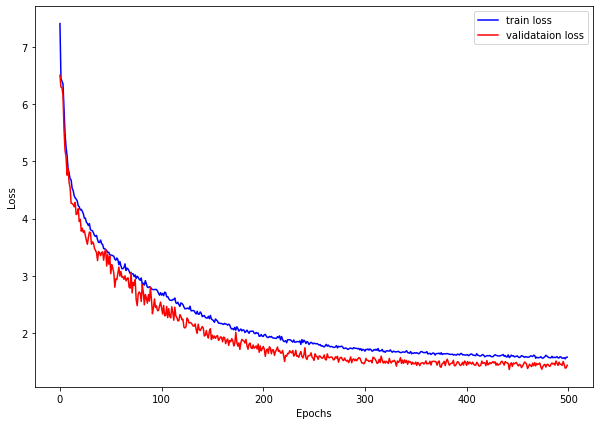

In [27]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [28]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [29]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [30]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [31]:
enc = tiktoken.encoding_for_model("gpt2")

In [32]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [33]:
generate_length = 128

In [34]:
sentences = [
    "Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning."
]

In [35]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning.
GENERATED SENTENCE WITH TEMPERATURE 0.1
Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning.  He  is  the  grass  is  a 
 If  for  the 
 mother .  out  against  the  hunter  is  known  by  merely  wishing  we  make  a  word .  on ,  I  go 
    Wonderful !  we  make ,  I  go 
 
                                                                St ocks  and  the  way  of  the  Monkey -  to  Shiv  to  do le  cut  up  by  where ,  gun ,  of  a  million  mouths  at  wolves  and  to  be  sure , ?  they  amounted  to  the  Monkey -  to  the  dance ?  they  shouted  and  picked  himself .  about  and  horses ,  of  the


GENERATED SENTENCE WITH TEMPERATURE 0.2
Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning.  � 
 
 saw  what  it �  stupid  as  well  as  th